<!-- :Author: Arthur Goldberg <Arthur.Goldberg@mssm.edu> -->
<!-- :Date: 2020-07-13 -->
<!-- :Copyright: 2020, Karr Lab -->
<!-- :License: MIT -->
# DE-Sim tutorial

DE-Sim is an open-source, object-oriented, discrete-event simulation (OO DES) tool implemented in Python.
DE-Sim makes it easy to build and simulate discrete-event models.
This page introduces the basic concepts of discrete-event modeling and teaches you how to build and simulate discrete-event models with DE-Sim. 

## Installation
Use `pip` to install `de_sim`.

## DE-Sim model of a one-dimensional random walk

A simple DE-Sim model can be defined in three steps: define an event message class; define a simulation object class; and build and run a simulation.
We illustrate this process with a model of a 
[random walk on the integer number line](https://en.wikipedia.org/wiki/Random_walk#One-dimensional_random_walk).

### 1: Create an event message class by subclassing `EventMessage`.

DES models execute events at discrete instants of time.
Each DE-Sim event contains an event message that provides data to the simulation object which executes the event.
The random walk model sends event messages that contain the value of a random step.

In [2]:
import de_sim

class RandomStepMessage(de_sim.EventMessage):
    "An event message class that stores the value of a random walk step"
    msg_field_names = ['step_value']

The attribute `msg_field_names` is a special attribute of an `EventMessage` that specifies the names of an event message class’s attributes.
These names must be valid Python identifiers.
`msg_field_names` is optional. 

An event message class must be documented by a docstring, as illustrated.

### 2: Define a simulation object class by subclassing `SimulationObject`.

Simulation objects are like threads, in that a simulation's scheduler decides when to execute them, and their execution is suspended when they have no work to do.
But DES simulation objects and threads are scheduled by different algorithms.
Whereas a thread can be scheduled whenever it has work to do,
a DES scheduler schedules simulation objects to ensure that events occur in simulation time order, as summarized by the fundamental invariant of discrete-event simulation:

1. All events in a simulation are executed in non-decreasing time order. (Events with equal simulation times are scheduled by DE-Sim according to the tie-breaking rules discussed in the [Ordering simultaneous events in DE-Sim](https://sandbox.karrlab.org/notebooks/de_sim/3.%20Ordering%20simultaneous%20events%20in%20DE-Sim.ipynb) notebook.) 

By guaranteeing this behavior, the DE-Sim scheduler ensures that causality relationships between events are respected.
(The invariant says *non-decreasing* instead of *increasing* time order because events can occur simultaneously, as discussed above.)

This invariant has two consequences:

1. All synchronization between simulation objects is controlled by the simulation times of events.
2. Each simulation object executes its events in non-decreasing time order.
(If a simulation object receives multiple events at a given simulation time, then it executes *all* of the events together, as discussed in the [Ordering simultaneous events in DE-Sim](https://sandbox.karrlab.org/notebooks/de_sim/3.%20Ordering%20simultaneous%20events%20in%20DE-Sim.ipynb) notebook.)

The Python classes that generate and handle simulation events are simulation object classes, which are defined as subclasses of `SimulationObject`.
DE-Sim provides a custom class creation method for `SimulationObject` that gives special meaning to certain methods and attributes.

Below, we define a simulation object class that models a random walk, and illustrates all key features of `SimulationObject`.
To add variety to its temporal behavior we modify the traditional random walk by randomly selecting the time delay between steps.

In [3]:
import random

class RandomWalkSimulationObject(de_sim.SimulationObject):
    " A one-dimensional random walk model, with random delays between steps "

    def __init__(self, name):
        super().__init__(name)

    def init_before_run(self):
        " Initialize before a simulation run; called by the simulator "
        self.position = 0
        self.history = {'times': [0],
                        'positions': [0]}
        self.schedule_next_step()

    def schedule_next_step(self):
        " Schedule the next event, which is a step "
        # A step moves -1 or +1 with equal probability
        step_value = random.choice([-1, +1])
        # The time between steps is 1 or 2, with equal probability
        delay = random.choice([1, 2])
        # Schedule an event `delay` in the future for this object
        # The event contains a `RandomStepMessage` with `step_value=step_value`
        self.send_event(delay, self, RandomStepMessage(step_value))

    def handle_step_event(self, event):
        " Handle a step event "
        # Update the position and history
        self.position += event.message.step_value
        self.history['times'].append(self.time)
        self.history['positions'].append(self.position)
        self.schedule_next_step()

    # `event_handlers` contains pairs that map each event message class
    # received by this simulation object to the method that handles
    # the event message class
    event_handlers = [(RandomStepMessage, handle_step_event)]

    # messages_sent registers all message types sent by this object
    messages_sent = [RandomStepMessage]

DE-Sim simulation objects (subclasses of `SimulationObject`) use these special methods and attributes:

* Special `SimulationObject` methods:
    1. **`init_before_run`** (optional): immediately before a simulation run, after all simulation objects have been added to a simulator, the simulator calls each simulation object’s `init_before_run` method. In this method simulation objects can send initial events and perform other initializations. For example, in `RandomWalkSimulationObject`, `init_before_run` schedules the object's first event and initializes the object's position and history attributes.
    2. **`send_event`**: `send_event(delay, receiving_object, event_message)` schedules an event to occur `delay` time units in the future at simulation object `receiving_object`. `event_message` must be an `EventMessage` instance. An event can be scheduled for any simulation object in a simulation, including the object scheduling the event, as `RandomWalkSimulationObject` does.
The event will be executed at its scheduled simulation time by an event handler in the simulation object `receiving_object`.
The handler defines an `event` parameter. 
Its value will be the scheduled event, which contains `event_message` in its `message` attribute.
Object-oriented DES terminology often describes the event message as being sent by the sending object at the message's send time (the simulation time when the sending object schedules the event) and being received by the receiving object at the event's receive time (the simulation time when the event is executed). An event message can thus be viewed as a directed edge in simulation space-time from the pair (sending object, send time) to (receiving object, receive time), as illustrated by \autoref{fig:phold_space_time_plot}.
    3. **event handlers**: an event handler is a method that handles and executes a simulation event. Event handlers have the signature `event_handler(self, event)`, where `self` is the simulation object that handles (receives) the event, and `event` is a simulation event. A subclass of `SimulationObject` must define at least one event handler, as illustrated by `handle_step_event` in the example above.
<br>
<br>
* Special `SimulationObject` attributes:
    1. **`event_handlers`**: a simulation object can receive arbitrarily many types of event messages, and implement arbitrarily many event handlers. The attribute `event_handlers` must contain an iterator over pairs that map each event message class received by a `SimulationObject` subclass to the event handler which handles the event message class. In the example above, `event_handlers` associates `RandomStepMessage` event messages with the `handle_step_event` event handler.
    2. **`messages_sent`**: the types of messages sent by a subclass of `SimulationObject` must be listed in `messages_sent`. It ensures that a simulation object doesn't send messages of the wrong `EventMessage` class.
    3. **`time`**: `time` is a read-only attribute that always equals the current simulation time in every simulation object. For example, a `RandomWalkSimulationObject` saves the value of `time` when recording its history.

### 3: Execute a simulation by creating and initializing a `Simulator`, and running the simulation.

The `Simulator` class simulates models.
Its `add_object` method adds a simulation object to the simulator.
Each object in a simulation must have a unique `name`.
The `initialize` method, which calls each simulation object’s `init_before_run` method, must be called before a simulation starts.
At least one simulation object in a simulation must schedule an initial event--otherwise the simulation cannot start.
More generally, a simulation with no events to execute will terminate.
Finally, `run` simulates a model. It takes the maximum time of a simulation run. `run` also takes several optional configuration arguments, as described in the DE-Sim [API documentation](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.simulator.Simulator.simulate).

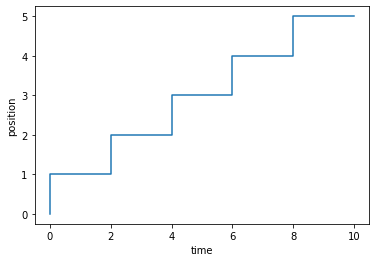

In [4]:
# Create a simulator
simulator = de_sim.Simulator()

# Create a random walk simulation object and add it to the simulation
random_walk_sim_obj = RandomWalkSimulationObject('rand_walk')
simulator.add_object(random_walk_sim_obj)

# Initialize the simulation
# This executes `init_before_run` in `random_walk_sim_obj`
simulator.initialize()

# Run the simulation until time 10
max_time = 10
simulator.run(max_time)

# Plot the random walk
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

fig, ax = plt.subplots()
loc = plticker.MultipleLocator(base=1.0)
ax.yaxis.set_major_locator(loc)
plt.step(random_walk_sim_obj.history['times'],
         random_walk_sim_obj.history['positions'],
         where='post')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

This example runs a simulation for `max_time` time units, and plots the random walk’s trajectory.
The random walk model starts at position 0 and moves +1 or -1 with equal probability at each step.
Steps take place every 1 or 2 time units, also with equal probability.
This trajectory illustrates two key characteristics of discrete-event models. First, the state, in this case the position, changes at discrete times.
Second, since the state does not change between instantaneous events, the trajectory of any state variable is a step function.
The source code for this model is available in the DE-Sim Git repository.

## DE-Sim example with multiple object instances

This section presents an implementation of the parallel hold (PHOLD) model, which is frequently used to benchmark parallel DES (PDES) simulators.
We implement PHOLD as a DE-Sim model and use it to illustrate these features:

* Use multiple `EventMessage` types
* Run multiple instances of a simulation object type
* Show simulation objects scheduling events for each other

In [5]:
""" Parallel hold (PHOLD) model commonly used to benchmark parallel discrete-event simulators :cite:`fujimoto1990performance`.
"""
import random

class MessageSentToSelf(de_sim.EventMessage):
    "A message that's sent to self"

class MessageSentToOtherObject(de_sim.EventMessage):
    "A message that's sent to another PHold simulation object"

class InitMsg(de_sim.EventMessage):
    'initialization message'

MESSAGE_TYPES = [MessageSentToSelf, MessageSentToOtherObject, InitMsg]


class PholdSimulationObject(de_sim.SimulationObject):
    """ Run a PHOLD simulation

    Attributes:
        args: a :obj:`Namespace` that defines:
            `num_phold_objects`: the number of PHOLD objects to run
            `frac_self_events`: the fraction of events sent to `self`
            `max_time`: the end time for the simulation
    """
    def __init__(self, name, args):
        self.args = args
        super().__init__(name)

    def init_before_run(self):
        self.send_event(random.expovariate(1.0), self, InitMsg())

    @staticmethod
    def record_event_header():
        print('\t'.join(('Sender',
                         'Send',
                         "Receivr",
                         'Event',
                         'Message type')))
        print('\t'.join(('', 'time', '', 'time', '')))
        
    def record_event(self, event):
        record_format = '{}\t{:.2f}\t{}\t{:.2f}\t{}'
        print(record_format.format(event.sending_object.name,
                                   event.creation_time,
                                   event.receiving_object.name,
                                   self.time,
                                   type(event.message).__name__))

    def handle_simulation_event(self, event):
        """ Handle a simulation event """
        # Record this event
        self.record_event(event)
        # Schedule an event
        if random.random() < self.args.frac_self_events or \
            self.args.num_phold_objects == 1:
            receiver = self
        else:
            # Send the event to another randomly selected object
            # Pick an object index in [0, num_phold-2], and increment if self or greater
            obj_index = random.randrange(self.args.num_phold_objects - 1)
            if int(self.name) <= obj_index:
                obj_index += 1
            receiver = self.simulator.simulation_objects[str(obj_index)]

        if receiver == self:
            message_type = MessageSentToSelf
        else:
            message_type = MessageSentToOtherObject
        self.send_event(random.expovariate(1.0), receiver, message_type())

    event_handlers = [(sim_msg_type, 'handle_simulation_event') \
                      for sim_msg_type in MESSAGE_TYPES]

    # register the message types sent
    messages_sent = MESSAGE_TYPES


def create_and_run(args):

    # create a simulator
    simulator = de_sim.Simulator()

    # create simulation objects, and send each one an initial event message to self
    for obj_id in range(args.num_phold_objects):
        phold_obj = PholdSimulationObject(str(obj_id), args)
        simulator.add_object(phold_obj)

    # run the simulation
    simulator.initialize()
    PholdSimulationObject.record_event_header()
    event_num = simulator.simulate(args.max_time).num_events
    print("Executed {} events.\n".format(event_num))

The PHOLD model runs multiple instances of `PholdSimulationObject`.
To simplify the example, each object's name is the string representation of its integer index.
`create_and_run` creates the objects and adds them to the simulator.

Each `PholdSimulationObject` object is initialized with `args`, a namespace object that defines two attributes used by all objects:

* `args.num_phold_objects`: the number of PHOLD objects running
* `args.frac_self_events`: the fraction of events sent to self

At time 0, each PHOLD object schedules an `InitMsg` event for itself that occurs after a random exponential time delay with mean = 1.0.

The `handle_simulation_event` method handles all events.
Each event schedules one more event.
A PHOLD object uses a U(0,1) random value to decide whether to schedule the event for itself (with probability `args.frac_self_events`) or for another PHOLD object.

If the event is scheduled for another PHOLD object, this line obtains a reference to the object: 

    receiver = self.simulator.simulation_objects[str(obj_index)]

It uses the attribute `self.simulator`, which always references the simulator that is running, and `self.simulator.simulation_objects`, a dictionary that maps simulation object names to simulation object instances.

The prediction generated by a simulation can be saved in many ways. This example simply prints them.

Each event is printed by `record_event`.
It accesses the DE-Sim `Event` object that is passed to all event handlers.
`de_sim.event.Event` contains five useful fields:

* `sending_object`: the object that created and sent the event
* `creation_time`: the simulation time when the event was created (a.k.a. its *send time*)
* `receiving_object`: the object that received the event
* `event_time`: the simulation time when the event must execute (a.k.a. its *receive time*)
* `message`: the `EventMessage` carried by the event

However, rather than use the event's `event_time`, `record_event` uses `self.time` to report the simulation time when the event is being executed, as they are always equal.

In [6]:
from argparse import Namespace
args = Namespace(max_time=4,
                 frac_self_events=0.3,
                 num_phold_objects=6)
create_and_run(args)

Sender	Send	Receivr	Event	Message type
	time		time	
2	0.00	2	0.10	InitMsg
3	0.00	3	0.16	InitMsg
1	0.00	1	1.02	InitMsg
2	0.10	4	1.05	MessageSentToOtherObject
0	0.00	0	1.09	InitMsg
0	1.09	4	1.18	MessageSentToOtherObject
1	1.02	0	1.27	MessageSentToOtherObject
3	0.16	0	1.31	MessageSentToOtherObject
4	1.05	2	1.31	MessageSentToOtherObject
2	1.31	1	1.55	MessageSentToOtherObject
4	0.00	4	1.60	InitMsg
1	1.55	2	1.83	MessageSentToOtherObject
0	1.31	1	1.90	MessageSentToOtherObject
0	1.27	4	1.94	MessageSentToOtherObject
2	1.83	4	2.08	MessageSentToOtherObject
1	1.90	1	2.13	MessageSentToSelf
5	0.00	5	2.31	InitMsg
5	2.31	5	2.58	MessageSentToSelf
4	1.18	1	3.20	MessageSentToOtherObject
4	1.60	3	3.30	MessageSentToOtherObject
1	3.20	5	3.33	MessageSentToOtherObject
1	2.13	3	3.48	MessageSentToOtherObject
4	2.08	5	3.51	MessageSentToOtherObject
5	2.58	3	3.69	MessageSentToOtherObject
3	3.69	4	3.76	MessageSentToOtherObject
Executed 25 events.

